In [1]:
import tensorflow as tf
config = tf.compat.v1.ConfigProto(
    gpu_options = tf.compat.v1.GPUOptions(per_process_gpu_memory_fraction=0.8),
)
config.gpu_options.allow_growth = True
session = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(session)

In [2]:
import warnings
import random
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
from amp.utils.basic_model_serializer import load_master_model_components
from amp.models.decoders import amp_expanded_decoder
from amp.models.encoders import amp_expanded_encoder
from amp.models.master import master
from amp.utils import basic_model_serializer, callback, generator
import amp.data_utils.data_loader as data_loader
from amp.config import hydra, pepcvae, basic
from amp.data_utils.sequence import pad, to_one_hot

from sklearn.model_selection import train_test_split
from pathlib import Path
from keras import backend, layers, activations, Model
from amp.utils import metrics as amp_metrics
from keras import models as m
from keras.optimizers import Adam
from tqdm import tqdm
from joblib import dump, load
from sklearn.decomposition import PCA
import os
import seaborn as sns
import matplotlib.pyplot as plt
params = {'axes.labelsize': 8,
         'axes.titlesize': 8,
         'xtick.labelsize': 8,
         'ytick.labelsize': 8}
plt.rcParams.update(params)
plt.rc('text', usetex=False)
sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})
# sns.set_context("notebook")

Using TensorFlow backend.


In [3]:
seed = 7
np.random.seed(seed)

In [4]:
from amp.config import MIN_LENGTH, MAX_LENGTH, LATENT_DIM, MIN_KL, RCL_WEIGHT, HIDDEN_DIM, MAX_TEMPERATURE

input_to_encoder = layers.Input(shape=(MAX_LENGTH,))
input_to_decoder = layers.Input(shape=(LATENT_DIM+2,))

In [5]:
def translate_generated_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el - 1] if el != 0 else "" for el in encoded_peptide[0].argmax(axis=1)])

def translate_peptide(encoded_peptide):
    alphabet = list('ACDEFGHIKLMNPQRSTVWY')
    return ''.join([alphabet[el-1] if el != 0 else "" for el in encoded_peptide])

In [6]:
models = [
    'HydrAMP',
    'PepCVAE',
    'Basic',
]

In [7]:
best_epochs = {
    'HydrAMP': 37,
    'PepCVAE': 35,
    'Basic': 15,
}

In [8]:
bms = basic_model_serializer.BasicModelSerializer()
amp_classifier = bms.load_model('../models/amp_classifier')
amp_classifier_model = amp_classifier()
mic_classifier = bms.load_model('../models/mic_classifier/')
mic_classifier_model = mic_classifier() 

# Get data

In [9]:
random.seed(seed)
data_manager = data_loader.AMPDataManager(
    '../data/unlabelled_positive.csv',
    '../data/unlabelled_negative.csv',
    min_len=MIN_LENGTH,
    max_len=MAX_LENGTH)

amp_x, amp_y = data_manager.get_merged_data()
amp_x_train, amp_x_test, amp_y_train, amp_y_test = train_test_split(amp_x, amp_y, test_size=0.1, random_state=36)
amp_x_train, amp_x_val, amp_y_train, amp_y_val = train_test_split(amp_x_train, amp_y_train, test_size=0.2, random_state=36)

In [10]:
# Restrict the length
ecoli_df = pd.read_csv('../data/mic_data.csv')
mask = (ecoli_df['sequence'].str.len() <= MAX_LENGTH) & (ecoli_df['sequence'].str.len() >= MIN_LENGTH)
ecoli_df = ecoli_df.loc[mask]
mic_x = pad(to_one_hot(ecoli_df['sequence']))
mic_y = ecoli_df.value

mic_x_train, mic_x_test, mic_y_train, mic_y_test = train_test_split(mic_x, mic_y, test_size=0.1, random_state=36)
mic_x_train, mic_x_val, mic_y_train, mic_y_val = train_test_split(mic_x_train, mic_y_train, test_size=0.2, random_state=36)

In [11]:
n=64

pos = np.vstack([amp_x_test[amp_y_test == 1], mic_x_test[mic_y_test < 1.5]])
neg = np.vstack([amp_x_test[amp_y_test == 0], mic_x_test[mic_y_test > 1.5]])

pos_amp = amp_classifier_model.predict(pos, verbose=1).reshape(len(pos))
neg_mic = mic_classifier_model.predict(neg, verbose=1).reshape(len(neg))
neg_amp = amp_classifier_model.predict(neg, verbose=1).reshape(len(neg))
pos_mic = mic_classifier_model.predict(pos, verbose=1).reshape(len(pos))

pos = np.vstack([pos] * n).reshape(-1, 25)
pos_amp = np.vstack([pos_amp] * n).reshape(-1, 1)
pos_mic = np.vstack([pos_mic] * n).reshape(-1, 1)
neg = np.vstack([neg] * n).reshape(-1, 25)
neg_amp = np.vstack([neg_amp] * n).reshape(-1, 1)
neg_mic = np.vstack([neg_mic] * n).reshape(-1, 1)

1319/1319 [==============================] - 0s 114us/step


In [12]:
def get_z_sigma(x):
    inputs = layers.Input(shape=(25,))
    z_mean, z_sigma, z = AMPMaster.encoder.output_tensor(inputs)
    temp_encoder = m.Model(inputs, [z_mean, z_sigma, z])
    z_mean, z_sigma, z = temp_encoder.predict(x) 
    return np.exp(z_sigma / 2)

In [13]:
def improve(seq, amp, mic, z_sigma, temp=0.0):
    z = encoder_model.predict(seq, batch_size=5000)
    noise = np.random.normal(loc=0, scale=temp*z_sigma, size=z.shape)
    encoded = z + noise
    conditioned = np.hstack([
        encoded,
        np.ones((len(seq), 1)),
        np.ones((len(seq), 1)),
    ])
    decoded = decoder_model.predict(conditioned, batch_size=5000)
    new_peptides = np.argmax(decoded, axis=2)
    new_amp = amp_classifier_model.predict(new_peptides, batch_size=5000)
    new_mic = mic_classifier_model.predict(new_peptides, batch_size=5000)                                                                             
    
    # RELATIVE
    rel_better = new_amp > amp.reshape(-1, 1)
    rel_better = rel_better & (new_mic > mic.reshape(-1, 1))
    rel_better = np.logical_or.reduce(rel_better, axis=1)
    rel_improved = new_peptides[np.where(rel_better), :].reshape(-1, 25)
    before_rel_improve = seq[np.where(rel_better), :].reshape(-1, 25)
    
    # ABSOLUTE
    abs_better = new_amp >= 0.8
    abs_better = abs_better & (new_mic > 0.5)
    abs_better = np.logical_or.reduce(abs_better, axis=1)
    abs_improved = new_peptides[np.where(abs_better), :].reshape(-1, 25)
    before_abs_improve = seq[np.where(abs_better), :].reshape(-1, 25)
    
    return {
        'new_peptides': new_peptides,
        'rel_improved': rel_improved,
        'abs_improved': abs_improved,
        'before_rel_improve': before_rel_improve,
        'before_abs_improve': before_abs_improve, 
        'new_amp': new_amp,
        'new_mic': new_mic,
        }                                                                  

In [14]:
tau = backend.variable(1.0, name="temperature")

In [15]:
model = 'HydrAMP'
AMPMaster = bms.load_model(f'../models/{model}/{best_epochs[model]}')
encoder_model =  AMPMaster.encoder(input_to_encoder)
AMPMaster.decoder.activation.temperature = tau
decoder_model = AMPMaster.decoder(input_to_decoder)             

tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=0.1> temperature
tracking <tf.Variable 'temperature:0' shape=() dtype=float32, numpy=1.0> temperature


# Positives, negatives

In [16]:
temps =  np.linspace(0,5,num=21)
pos_analogues = []
neg_analogues = []
pos_z_sigma = get_z_sigma(pos)
neg_z_sigma = get_z_sigma(neg)
for temp in tqdm(temps):
    pos_analogues.append(np.unique(improve(pos, pos_amp, pos_mic, pos_z_sigma, temp=temp)['rel_improved'], axis=0))
    neg_analogues.append(np.unique(improve(neg, neg_amp, neg_mic, neg_z_sigma, temp=temp)['abs_improved'], axis=0))

100%|██████████| 21/21 [01:14<00:00,  3.56s/it]


In [17]:
no_pos_analogues = [len(x) for x in pos_analogues]
no_neg_analogues = [len(x) for x in neg_analogues]

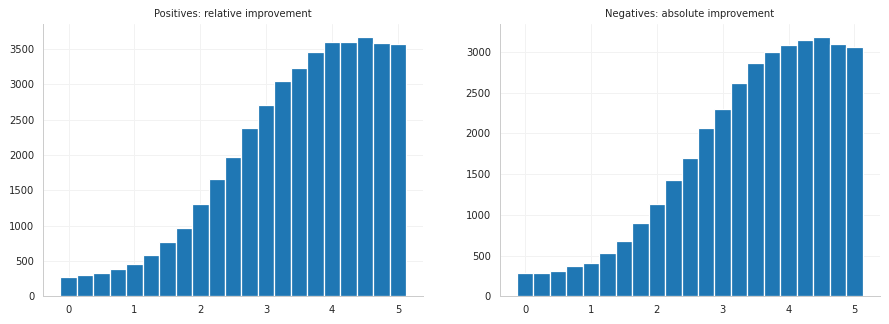

In [18]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    dpi=90,
)

ax1.bar(temps, no_pos_analogues, width=0.25)
ax1.set_title('Positives: relative improvement')
ax2.bar(temps, no_neg_analogues, width=0.25)
ax2.set_title('Negatives: absolute improvement')

plt.show()

In [19]:
neg

array([[11, 20, 16, ..., 13,  1,  0],
       [ 1, 15, 15, ...,  0,  0,  0],
       [ 8, 13, 11, ...,  0,  0,  0],
       ...,
       [ 5, 18, 10, ...,  0,  0,  0],
       [ 6,  8, 10, ...,  0,  0,  0],
       [ 6, 18, 16, ..., 16,  0,  0]], dtype=int32)

In [20]:
neg0 = improve(neg, neg_amp, neg_mic, neg_z_sigma, temp=0)
neg2 = improve(neg, neg_amp, neg_mic, neg_z_sigma, temp=2)
neg5 = improve(neg, neg_amp, neg_mic, neg_z_sigma, temp=5)

dump(neg0, f'../results/z_sigma_improvement_0_NegTest.joblib')
dump(neg2, f'../results/z_sigma_improvement_2_NegTest.joblib')
dump(neg5, f'../results/z_sigma_improvement_5_NegTest.joblib')

['../results/z_sigma_improvement_5_NegTest.joblib']

In [24]:
len(neg_amp)

80192

In [20]:
pos0 = improve(pos, pos_amp, pos_mic, pos_z_sigma, temp=0)
pos2 = improve(pos, pos_amp, pos_mic, pos_z_sigma, temp=2)
pos5 = improve(pos, pos_amp, pos_mic, pos_z_sigma, temp=5)

dump(pos0, f'../results/z_sigma_improvement_0_PosTest.joblib')
dump(pos2, f'../results/z_sigma_improvement_2_PosTest.joblib')
dump(pos5, f'../results/z_sigma_improvement_5_PosTest.joblib')

['../results/z_sigma_improvement_5_PosTest.joblib']

# Pexiganan, tenporin, CAMEL

In [22]:
def levenshteinDistanceDP(token1, token2):
    distances = np.zeros((len(token1) + 1, len(token2) + 1))

    for t1 in range(len(token1) + 1):
        distances[t1][0] = t1

    for t2 in range(len(token2) + 1):
        distances[0][t2] = t2
        
    a = 0
    b = 0
    c = 0
    
    for t1 in range(1, len(token1) + 1):
        for t2 in range(1, len(token2) + 1):
            if (token1[t1-1] == token2[t2-1]):
                distances[t1][t2] = distances[t1 - 1][t2 - 1]
            else:
                a = distances[t1][t2 - 1]
                b = distances[t1 - 1][t2]
                c = distances[t1 - 1][t2 - 1]
                
                if (a <= b and a <= c):
                    distances[t1][t2] = a + 1
                elif (b <= a and b <= c):
                    distances[t1][t2] = b + 1
                else:
                    distances[t1][t2] = c + 1

    return distances[len(token1)][len(token2)]

In [23]:
def get_unique(x):
    if x.shape[0] > 1:
        return np.unique(x, axis=0)
    else:
        return x

In [24]:
peptides = [
    'GIGKFLKKAKKFGKAFVKILKK', #pex
    'FLPLIGRVLSGIL', #temporin
    'KWKLFKKIGAVLKVL'  #camel
]

n = 10000
temps =  np.linspace(0,5,num=21)

In [25]:
no_analogues = []
levenshtein = []

for peptide in tqdm(peptides):
    pep = pad(to_one_hot([peptide]))
    amp = amp_classifier_model.predict(pep)
    mic = mic_classifier_model.predict(pep)
    z_sigma = get_z_sigma(pep)
    
    pep = np.vstack([pep] * n).reshape(-1, 25)
    amp = np.vstack([amp] * n)
    mic = np.vstack([mic] * n)
    
    analogues = []
    ld = []
    
    for temp in temps:
        analogue_batch = get_unique(improve(pep, amp, mic, z_sigma, temp=temp)['abs_improved'])
        analogues.append(analogue_batch)
        ld.append([levenshteinDistanceDP(peptide, translate_peptide(x)) for x in analogue_batch])

    no_analogues.append([len(x) for x in analogues])
    levenshtein.append(ld)


100%|██████████| 3/3 [01:09<00:00, 23.16s/it]


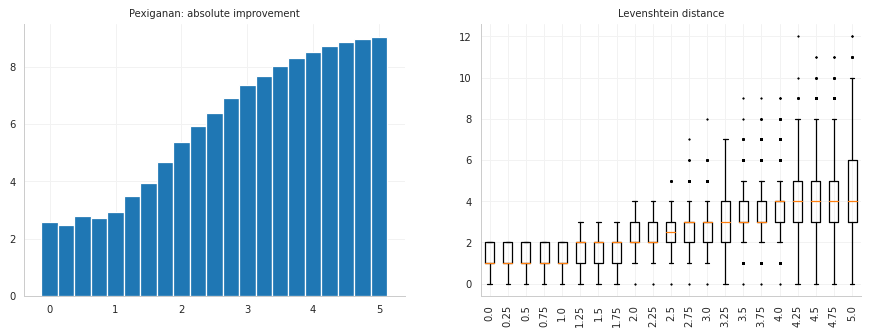

In [26]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    dpi=90,
)

# ax1.bar(temps, no_analogues[0], width=0.25)
ax1.bar(temps, np.log(no_analogues[0]), width=0.25)

ax1.set_title('Pexiganan: absolute improvement')

flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
ax2.boxplot(levenshtein[0], sym='+', flierprops=flierprops)
ax2.set_xticklabels(temps, rotation=90)
ax2.set_title('Levenshtein distance')

plt.show()

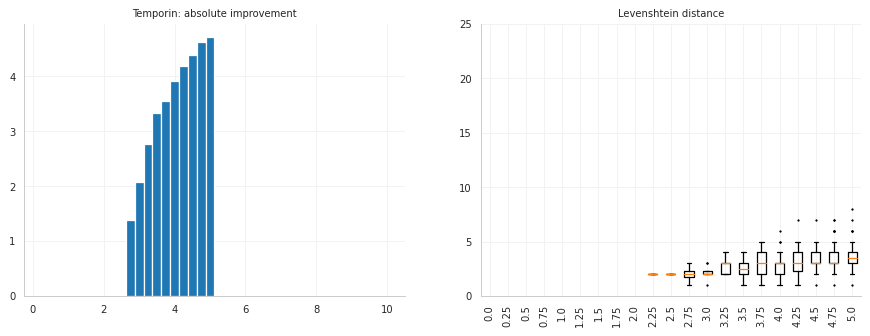

In [27]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    dpi=90,
)

# ax1.bar(temps, no_analogues[1], width=0.25)
ax1.set_xlim(-0.25,10.5)
ax1.bar(temps, np.log(no_analogues[1]), width=0.25)
ax1.set_title('Temporin: absolute improvement')

flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
ax2.boxplot(levenshtein[1], sym='+', flierprops=flierprops)
ax2.set_xticklabels(temps, rotation=90)
ax2.set_title('Levenshtein distance')
ax2.set_ylim(0, 25)

plt.show()

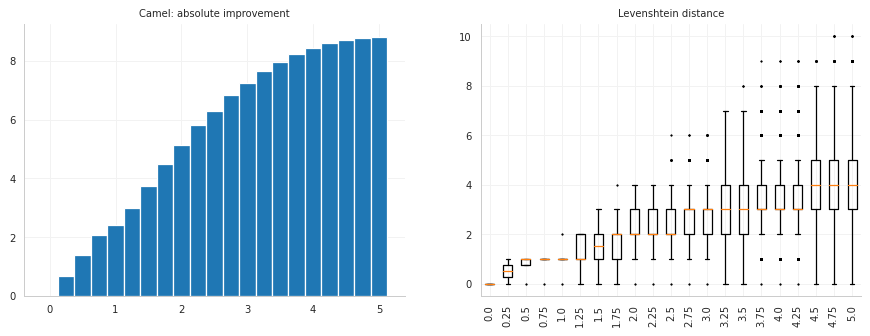

In [28]:
fig, (ax1, ax2) = plt.subplots(
    nrows=1,
    ncols=2,
    figsize=(12, 4),
    dpi=90,
)

# ax1.bar(temps, no_analogues[2], width=0.25)
ax1.bar(temps, np.log(no_analogues[2]), width=0.25)

ax1.set_title('Camel: absolute improvement')

flierprops = dict(marker='o', markersize=1,
                  linestyle='none')
ax2.boxplot(levenshtein[2], sym='+', flierprops=flierprops)
ax2.set_xticklabels(temps, rotation=90)
ax2.set_title('Levenshtein distance')

plt.show()

In [29]:
temps = [0, 2, 5]
no_analogues = []
levenshtein = []

for peptide in tqdm(peptides):
    pep = pad(to_one_hot([peptide]))
    amp = amp_classifier_model.predict(pep)
    mic = mic_classifier_model.predict(pep)
    z_sigma = get_z_sigma(pep)
    
    pep = np.vstack([pep] * n).reshape(-1, 25)
    amp = np.vstack([amp] * n)
    mic = np.vstack([mic] * n)
    
    analogues = []
    ld = []
    
    for temp in temps:
        analogue_batch = get_unique(improve(pep, amp, mic, z_sigma, temp=temp)['abs_improved'])
        analogues.append(analogue_batch)
        ld.append([levenshteinDistanceDP(peptide, translate_peptide(x)) for x in analogue_batch])

    no_analogues.append([len(x) for x in analogues])
    levenshtein.append(ld)


100%|██████████| 3/3 [00:18<00:00,  6.04s/it]


In [30]:
pex_temp_camel = {'no_analogues': no_analogues, "ld": levenshtein}
dump(pex_temp_camel, f'../results/PexTempCamel.joblib')

['../results/PexTempCamel.joblib']